In [10]:
# %matplotlib notebook
%matplotlib inline

import copy
import numpy as np
import random
import matplotlib.pyplot as plt
import json
from collections import deque
from _converter_v2 import Event2Dict
from _evaluation import print_metrics

_true = "true"
_false = "false"
path = ""

Quality_OK is mapped to Faultiness
* 'False' -> 1 (Faulty)
* 'True'  -> 0 (Good)

In [11]:
def load(prod_id, mx=0):
    filename = path+"layouts/"+prod_id+".json"
    print("Loading layout... {}".format(filename))
    with open(filename) as j:    
        layout = json.load(j)

    filename = prod_id+".txt"
    data = []
    times = []
    bad = 0
    
    print("Loading rows... {}".format(filename))
    with open(path+filename) as f:
        i = 0
        for line in f:
            i = i+1
            if mx>0 and i>mx:
                break
                
            try:
                features, timestamps = Event2Dict(json.loads(line), layout)
                data.append(features.values())
                times.append(timestamps.values())
            except Exception, e:
                print(e)
                break
                bad+=1

    print("Errors: {}".format(bad))
    print("Loaded: {}".format(len(data)))

    """ random split seed """
    data, times = np.asarray(data), np.asarray(times)
    # print(data.shape, times.shape)
    mask = np.random.rand(len(data)) < 0.9
    print("Total: {} Good: {} Faulty: {} Ratio: {}".format(len(data), len(data[data[:,-1]==_true]), len(data[data[:,-1]==_false]), len(data[data[:,-1]==_false])/float(len(data[data[:,-1]==_true]))))
    return data, times, mask, layout

In [12]:
""" Logistic Sub-Sample """
from scipy.stats import logistic

# Take random numbers from a logistic probability density function
def logistic_choice(total, sample_size, replace=False):
    p = logistic.pdf(np.arange(0,total), loc=0, scale=total/5)
    p /= np.sum(p)
    return np.random.choice(total, size=sample_size, replace=replace, p=p)

def subsample(train, quiet=False):
    faulty = train[train[:,-1]==_false]
    not_faulty = train[train[:,-1]==_true]
    fr = len(faulty)/float(len(train))
    if not quiet:
        print("Train Total: {} Good: {} Faulty: {} Ratio: {}".format(len(train), len(not_faulty), len(faulty), fr))
        print("Test  Total: {} Good: {} Faulty: {} Ratio: {}".format(len(test), len(test[test[:,-1]==_true]), len(test[test[:,-1]==_false]), float(len(test[test[:,-1]==_false]))/len(test)))

        print("Re-sampling...")
        
    sample_size = np.min([5000, len(not_faulty)])
    samples = logistic_choice(len(not_faulty), sample_size)
    # TODO: Upsample faulties with logistic_choice(replace=True)
    f_sample_size = np.min([1000, len(faulty)])
    f_samples = logistic_choice(len(faulty), f_sample_size)
    # Put samples together and shuffle
    train = np.concatenate((not_faulty[samples], faulty[f_samples]))
    train = np.random.permutation(train)

    fr = len(train[train[:,-1]==_false])/float(len(train))
    if not quiet:
        print("Train Total: {} Good: {} Faulty: {} Ratio: {}".format(len(train), len(train[train[:,-1]==_true]), len(train[train[:,-1]==_false]), fr))

    return train

## Accuracy

In [70]:
""" load data """
data, _, mask, _ = load("ABU1")
train = data[mask]
test = data[~mask]

test_data = test[:,2:-1].astype(np.float32)
test_labels = np.array(test[:,-1]==_false).astype(np.int32)
train_data = train[:,2:-1].astype(np.float32)
train_labels = np.array(train[:,-1]==_false).astype(np.int32)
# sub-sample
train_s = subsample(train)
train_data_s = train_s[:,2:-1].astype(np.float32)
train_labels_s = np.array(train_s[:,-1]==_false).astype(np.int32)

Loading layout... ../offline/layouts/ABU1.json
Loading rows... ABU1.txt
Errors: 0
Loaded: 212100
Total: 212100 Good: 200168 Faulty: 11932 Ratio: 0.0596099276608
Train Total: 190919 Good: 180147 Faulty: 10772 Ratio: 0.0564218333429
Test  Total: 21181 Good: 20021 Faulty: 1160 Ratio: 0.0547660639252
Re-sampling...
Train Total: 6000 Good: 5000 Faulty: 1000 Ratio: 0.166666666667


In [71]:
# balance the train set (for accuracy metric)
balanced = True
if balanced:
    faulty = test[test[:,-1]==_false]
    not_faulty = test[test[:,-1]==_true]
    test = np.concatenate((not_faulty[:len(faulty)], faulty))
    test_data = test[:,2:-1].astype(np.float32)
    test_labels = np.array(test[:,-1]==_false).astype(np.int32)

In [72]:
""" Random Forest """
from sklearn.ensemble import RandomForestClassifier

# ALL
clf = RandomForestClassifier(n_estimators=100, max_depth=90, n_jobs=4)
%time clf = clf.fit(train_data, train_labels)
# print_metrics(full_train_labels, clf.predict(full_train_data))
print_metrics(test_labels, clf.predict(test_data))

# SUBSAMPLE
clf = RandomForestClassifier(n_estimators=100, max_depth=90, n_jobs=4)
%time clf = clf.fit(train_data_s, train_labels_s)
# print_metrics(train_labels_s, clf.predict(train_data_s))
print_metrics(test_labels, clf.predict(test_data))

CPU times: user 14min 56s, sys: 2.39 s, total: 14min 58s
Wall time: 3min 45s
------------------------- EVALUATION -------------------------
Accuracy Score: 0.980172413793
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      1160
          1       1.00      0.96      0.98      1160

avg / total       0.98      0.98      0.98      2320

Confusion Matrix:
[[1160    0]
 [  46 1114]]
Kappa Score: 0.960344827586
Matthews Correlation Coefficient: 0.961100806126
--------------------------------------------------------------
CPU times: user 14.4 s, sys: 150 ms, total: 14.6 s
Wall time: 3.97 s
------------------------- EVALUATION -------------------------
Accuracy Score: 0.975862068966
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      1160
          1       1.00      0.95      0.98      1160

avg / total       0.98      0.98      0.98      2320

Confusion Matrix:
[[1158    2]
 [  54 1106]]
Kappa 

## Accuacy vs. Number of Datapoints

In [13]:
""" load data """
# mx = 50000
# D = {}
# for n in range(1,6+1):
#     prod_id = "ABU{}".format(n)
#     data, _, mask = load(prod_id, mx)
#     D[prod_id] = {
#         'data': data, 
#         'mast': mask
#     }

data, _, mask, _ = load("ABU1")
test = data[~mask]
test_data = test[:,2:-1].astype(np.float32)
test_labels = np.array(test[:,-1]==_false).astype(np.int32)

train = data[mask]
faulty = train[train[:,-1]==_false]
not_faulty = train[train[:,-1]==_true]

ratio = 0.95/0.05

Loading layout... ../offline/layouts/ABU1.json
Loading rows... ABU1.txt
Errors: 0
Loaded: 212100
Total: 212100 Good: 200168 Faulty: 11932 Ratio: 0.0596099276608


In [14]:
""" Random Forest """
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf = RandomForestClassifier(n_estimators=100, max_depth=90, n_jobs=4)
MCCs = []
HLs = []
print("Total\tMCC\tHL")
for tr in xrange(10,1720,50):
    small = np.concatenate((not_faulty[:int(tr*ratio)], faulty[:tr]))
    small_data = small[:,2:-1].astype(np.float32)
    small_labels = np.array(small[:,-1]==_false).astype(np.int32)
    clf = clf.fit(small_data, small_labels)
    predicted_labels = clf.predict(test_data)
    mcc = metrics.matthews_corrcoef(test_labels, predicted_labels)
    hl = metrics.hamming_loss(test_labels, predicted_labels)
    print("{}\t{}\t{}".format(len(small), mcc, hl))
    MCCs.append(mcc)
    HLs.append(hl)

Total	MCC	HL
199	0.0	0.0555921052632
1199	0.317512661415	0.0502819548872
2199	0.565256614624	0.0373120300752
3199	0.670177117616	0.0300281954887
4199	0.772397993341	0.0218045112782
5199	0.837308573511	0.0160244360902
6199	0.869771043627	0.0130169172932
7199	0.881180450926	0.0119360902256
8199	0.903716972859	0.00972744360902
9199	0.904302279291	0.00968045112782
10199	0.923022603267	0.0078477443609
11199	0.943301199144	0.00582706766917
12199	0.946638168353	0.00549812030075
13199	0.947530995077	0.00540413533835
14199	0.947063148539	0.00545112781955
15199	0.953038198187	0.00484022556391
16199	0.967849492507	0.00333646616541
17199	0.971485237413	0.00296052631579
18199	0.968732244604	0.00324248120301
19199	0.964595112445	0.00366541353383
20199	0.970566873681	0.0030545112782
21199	0.972855290771	0.00281954887218
22199	0.981061379025	0.00197368421053
23199	0.971940113721	0.00291353383459
24199	0.969190416976	0.0031954887218
25199	0.982877874614	0.00178571428571
26199	0.983784948868	0.001691729

In [35]:
""" Gradient Boosting """
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

clf = GradientBoostingClassifier(loss='deviance', n_estimators=100,  max_depth=15, learning_rate=0.1)
GBMCCs = []
GBHLs = []
print("Total\tMCC\tHL")
for tr in xrange(10,1720,50):
    small = np.concatenate((not_faulty[:int(tr*ratio)], faulty[:tr]))
    small_data = small[:,2:-1].astype(np.float32)
    small_labels = np.array(small[:,-1]==_false).astype(np.int32)
    clf = clf.fit(small_data, small_labels)
    predicted_labels = clf.predict(test_data)
    mcc = metrics.matthews_corrcoef(test_labels, predicted_labels)
    hl = metrics.hamming_loss(test_labels, predicted_labels)
    print("{}\t{}\t{}".format(len(small), mcc, hl))
    GBMCCs.append(mcc)
    GBHLs.append(hl)

Total	MCC	HL
199	0.0341275030917	0.103195488722
1199	0.467519401281	0.0444078947368
2199	0.655992347631	0.03125
3199	0.703336273807	0.0276785714286
4199	0.81060915413	0.0186560150376
5199	0.847410283171	0.0151785714286
6199	0.859424446609	0.0140507518797
7199	0.877134313912	0.0123120300752
8199	0.885681148117	0.0114661654135
9199	0.896416305611	0.0104323308271
10199	0.92964695409	0.00718984962406
11199	0.937171793869	0.00643796992481
12199	0.947063148539	0.00545112781955
13199	0.945671973888	0.00559210526316
14199	0.943313711125	0.00582706766917
15199	0.945575473536	0.00559210526316
16199	0.956302885893	0.00451127819549
17199	0.955347133112	0.00460526315789
18199	0.960904401516	0.00404135338346
19199	0.952558834245	0.00488721804511
20199	0.961366153265	0.00399436090226
21199	0.971024256038	0.00300751879699
22199	0.975140268555	0.00258458646617
23199	0.962749901913	0.00385338345865
24199	0.972397787201	0.00286654135338
25199	0.967813819612	0.00333646616541
26199	0.965514705055	0.0035714

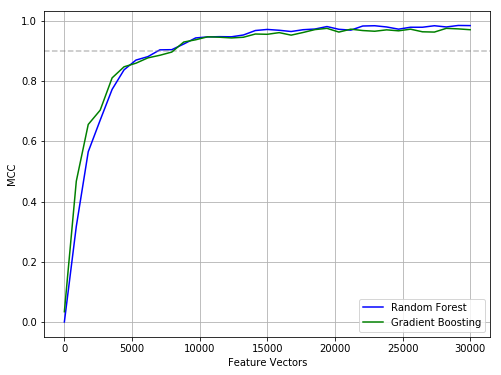

In [81]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', quality=100)

rrange = xrange(0,30000,int(np.ceil(30000/34)))
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(111)
ax1.set_ylabel('MCC')
ax1.set_xlabel("Feature Vectors")

# RF
p = ax1.plot(rrange, MCCs, label="Random Forest", color='b')
ax1.axhline(y=0.9, color='gray', linestyle='dashed', alpha=.5)
ax1.grid(True)
ax1.legend(loc=4)
# GB
ax3 = fig.add_subplot(111)
ax3.plot(rrange, GBMCCs, label="Gradient Boosting", color="g")
ax3.legend(loc=4)

plt.show()

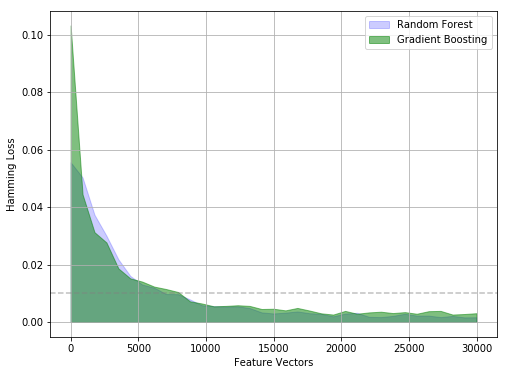

In [82]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', quality=100)

rrange = xrange(0,30000,int(np.ceil(30000/34)))
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(111)
ax1.set_ylabel('Hamming Loss')
ax1.set_xlabel("Feature Vectors")

# RF
p = ax1.fill_between(rrange, HLs, label="Random Forest", alpha=0.2, color='b')
ax1.grid(True)
ax1.axhline(y=0.01, color='gray', linestyle='dashed', alpha=.5)
ax1.legend(loc=1)
# GB
ax2 = fig.add_subplot(111)
ax2.fill_between(rrange, GBHLs, label="Gradient Boosting", alpha=0.5, color='g')
ax2.grid(True)
ax2.legend(loc=1)

plt.show()

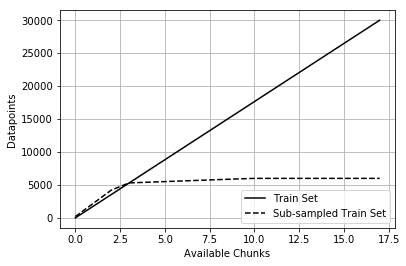

In [200]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', quality=100)

rrange = xrange(0,30000,int(np.ceil(30000/17)))
arange = xrange(0,18,1)
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.set_ylabel('Datapoints')
ax1.set_xlabel('Available Chunks')
p = ax1.plot(arange, rrange, label="Train Set", color="black")
ax1.grid(True)
ax1.legend(loc=4)

ax3 = fig.add_subplot(111)
ax3.plot(arange, subs_size, label="Sub-sampled Train Set", color="black", linestyle='--')
ax3.legend(loc=4)

plt.show()

## Early Detection Rate

In [73]:
""" load data """
data, times, mask, layout = load("ABU5")
train = data[mask]
test = data[~mask]

test_data = test[:,2:-1].astype(np.float32)
test_labels = np.array(test[:,-1]==_false).astype(np.int32)
train_data = train[:,2:-1].astype(np.float32)
train_labels = np.array(train[:,-1]==_false).astype(np.int32)

faulty = train[train[:,-1]==_false]
not_faulty = train[train[:,-1]==_true]
means = np.mean(not_faulty[:,2:-1].astype(np.float32), axis=0)

# sub-sample
train_s = subsample(train)
train_data_s = train_s[:,2:-1].astype(np.float32)
train_labels_s = np.array(train_s[:,-1]==_false).astype(np.int32)

Loading layout... ../offline/layouts/ABU5.json
Loading rows... ABU5.txt
Errors: 0
Loaded: 98600
Total: 98600 Good: 93068 Faulty: 5532 Ratio: 0.0594404091632
Train Total: 88798 Good: 83842 Faulty: 4956 Ratio: 0.0558120678394
Test  Total: 9802 Good: 9226 Faulty: 576 Ratio: 0.0587635176495
Re-sampling...
Train Total: 6000 Good: 5000 Faulty: 1000 Ratio: 0.166666666667


In [74]:
""" Random Forest """
from sklearn.ensemble import RandomForestClassifier

# Use subsample
clf = RandomForestClassifier(n_estimators=100, max_depth=90, n_jobs=4)
%time clf = clf.fit(train_data_s, train_labels_s)
# print_metrics(train_labels_s, clf.predict(train_data_s))
print_metrics(test_labels, clf.predict(test_data))

Wall time: 3.85 s
------------------------- EVALUATION -------------------------
Accuracy Score: 0.993572740257
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      9226
          1       0.93      0.97      0.95       576

avg / total       0.99      0.99      0.99      9802

Confusion Matrix:
[[9183   43]
 [  20  556]]
Kappa Score: 0.942965846893
Matthews Correlation Coefficient: 0.943170327338
--------------------------------------------------------------


In [75]:
from sklearn import metrics
# test with partial feature vectors
# check_at = ["PasteInspection/PosY6", "AOI1/PosY6", "AOI2/PosY6"] # ABU1-3, ABU5-6
check_at = ["PasteInspection/PosX5", "AOI1/PosX5", "AOI2/PosX5"] # ABU4
check_at_index = []
for name in check_at:
    check_at_index.append(layout["measurements"].index(name))

CMs = []
for i in check_at_index:
    snapshot = copy.deepcopy(test_data)
    for r in snapshot:
        r[i:] = means[i:]
    
    predictions = clf.predict(snapshot)
    cm = metrics.confusion_matrix(test_labels, predictions)
    print np.where(predictions==1)[0].shape
    print cm
    CMs.append(cm)
    
CMs = np.asarray(CMs)
N = CMs[:,1,0]+CMs[:,1,1]
TN = CMs[:,1,1]
print TN/N.astype(np.float32)

(131L,)
[[9218    8]
 [ 453  123]]
(308L,)
[[9211   15]
 [ 283  293]]
(498L,)
[[9193   33]
 [ 111  465]]
[ 0.21354167  0.50868056  0.80729167]


## Early Detection - Saving Production Time

In [76]:
from sklearn import metrics
# test with partial feature vectors
# check_at = ["PasteInspection/PosY6", "AOI1/PosY6", "AOI2/PosY6"] # ABU1-3, ABU5-6
check_at = ["PasteInspection/PosX5", "AOI1/PosX5", "AOI2/PosX5"] # ABU4
check_at_index = []
for name in check_at:
    check_at_index.append(layout["measurements"].index(name))

CMs = []
total_TN = 0
total_FP = 0
total_saved = 0
total_wasted = 0
for i in check_at_index:
    snapshot = copy.deepcopy(test_data)
    for r in snapshot:
        r[i:] = means[i:]
    
    predictions = clf.predict(snapshot)
    cm = metrics.confusion_matrix(test_labels, predictions)
    print cm
    ####
    TN = cm[1,1] - total_TN
    total_TN += TN
    saved = times[0][-1]-times[0][i+2]
#     print TN, saved
    total_saved += TN*saved
    ####
    FP = cm[0,1] - total_FP
    total_FP += FP
    wasted = times[0][i+2]-times[0][0]
#     print FP, wasted
    total_wasted += FP*wasted
    
total = times[0][-1]-times[0][0] # assuming they all take same time
print "Production duration:", total/3600.
total *= len(test_data)

print "Total Saved:", total_saved/3600.0
print "Total Wasted:", total_wasted/3600.0
print "Total Spent (if not detected):", total/3600.0

[[9218    8]
 [ 453  123]]
[[9211   15]
 [ 283  293]]
[[9193   33]
 [ 111  465]]
Production duration: 3.94722222222
Total Saved: 1022.05833333
Total Wasted: 76.1833333333
Total Spent (if not detected): 38690.6722222
